In [1]:
! nvidia-smi | grep W

| N/A   51C    P0   113W / 149W |   2194MiB / 11441MiB |     85%      Default |
| N/A   34C    P0    74W / 149W |  10976MiB / 11441MiB |      0%      Default |
| N/A   37C    P8    29W / 149W |     11MiB / 11441MiB |      0%      Default |
| N/A   44C    P0   117W / 149W |   2963MiB / 11441MiB |     87%      Default |


In [2]:
# Switch to and available GPU 

import os
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = "cuda:0"

In [3]:
# Import dependencies

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
from torch.utils.data import random_split
import time
import numpy

# CNN architecture
Spectrogram image size -> X -> (129,6,6)
Image Labels -> Y -> (x,y)

Input Image: (129,6,6)
After convolution size -> floor( [n + 2p - f]/s + 1)
n = height or width sieze, p = padding size (f-1/2), f = filter size (e.g. 3*3 or 5*5) 

### Conv1   ---> Parameters: 90
f1 = 3*3, n1 = 10, p = 1, s = 1
Size after Conv1 -> (129, 6, 10)

### MaxPool1
f1 = 2*2, p = same, s = 2
Size after MaxPool1 -> (64, 3, 10)

### Conv2   ---> Parameters: 135
f2 = 3*3, n2 = 15, s = 2
Size after Conv2 -> (32, 1, 15)

### Flatten -> 480 

### FC 1   ---> Parameters: 61,440
(input, output) -> (480, 128)

### FC 2   ---> Parameters: 8192
(input, output) -> (128,64)

### FC 3   ---> Parameters: 128
(input, output) -> (64,2)

### Total Parameters: 69760

In [4]:
# Import the numpy arrays into tensors 

x_6_array = np.load('/home/takacMLGroup/ved/Data_Pre_Processing/X_6.npy')
y_6_array = np.load('/home/takacMLGroup/ved/Data_Pre_Processing/Y_6.npy')

x_7_array = np.load('/home/takacMLGroup/ved/Data_Pre_Processing/X_7.npy')
y_7_array = np.load('/home/takacMLGroup/ved/Data_Pre_Processing/Y_7.npy')

x_combined = np.concatenate((x_6_array, x_7_array), axis=0)
y_combined = np.concatenate((y_6_array, y_7_array), axis=0)

print("The number of combined samples: ", len(x_combined))

The number of combined samples:  4913


In [5]:
# Getting X and Y features and labels only from the new sample
X_combined = torch.from_numpy(x_combined)
Y_combined = torch.from_numpy(y_combined).float()

# Split into training and testing sets
test_split = .2
shuffle_dataset = True
random_seed= 40

# Creating data indices for training and validation splits:
dataset_size = len(X_combined)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

X_combined_train, Y_combined_train = X_combined[train_indices,:,:,:], Y_combined[train_indices,:] 
X_combined_test, Y_combined_test = X_combined[test_indices,:,:,:], Y_combined[test_indices,:] 

print("The original no. of samples are: ", len(X_combined))
print("The no. of training samples are: ", len(X_combined_train))
print("The no. of testing samples are: ", len(X_combined_test))

The original no. of samples are:  4913
The no. of training samples are:  3931
The no. of testing samples are:  982


In [6]:
# Defining the NN architecture 

class Net(nn.Module):
    
    def __init__(self, prob):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(6, 10, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(10, 15, 3, stride=2)
        self.fc1 = nn.Linear(15 * 32 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=prob)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 15 * 32 * 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [8]:
# Model Trianing 

weight_decay = [2**-i for i in range(10)]
training_loss = {}
testing_loss = {}
criterion = nn.MSELoss()
batch_size = 128
n_iterations = X_combined_train.shape[0] // batch_size


for w in weight_decay:
    
    beta = 0.999
    running_loss = 0
    c = 0
    training_loss['training_loss_f_expsm_w_%s' % w] = []
    testing_loss['testing_loss_f_expsm_w_%s' % w] = []
    torch.manual_seed(0)    
    net = Net(prob=0).cuda()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=w)

    np.random.seed(1) # Seed for model trained on Sample 6
    allTrainSamples = list(range((X_combined_train.shape[0])))

    for epoch in range(500):  # loop over the dataset multiple times
        
        np.random.shuffle(allTrainSamples)

        for i in range(n_iterations):

            # get the inputs; data is a list of [inputs, labels]           
            inputs = X_combined_train[allTrainSamples[i*batch_size:(i+1)*batch_size],:,:,:]
            labels = Y_combined_train[allTrainSamples[i*batch_size:(i+1)*batch_size],:]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss = beta*running_loss + (1-beta)*loss.item()
            c += 1

        with torch.no_grad():
            y_pred = net(X_combined_test.cuda())
            test_loss = criterion(y_pred, Y_combined_test.cuda())
        testing_loss['testing_loss_f_expsm_w_%s' % w].append(test_loss)
        training_loss['training_loss_f_expsm_w_%s' % w].append( running_loss / ( (1-beta**c) * n_iterations) )

        if epoch+1 == 500 or epoch == 0:    # print every start and end of training pass
            print(" Weight Decay: %f Epoch: %d Training Error: %.6f Testing Error: %.6f " 
                                  % (w, epoch+1, training_loss['training_loss_f_expsm_w_%s' % w][epoch]
                                                     , testing_loss['testing_loss_f_expsm_w_%s' % w][epoch]))
            print("----------------------------------")

 Weight Decay: 1.000000 Epoch: 1 Training Error: 0.004604 Testing Error: 0.066225 
----------------------------------
 Weight Decay: 1.000000 Epoch: 500 Training Error: 0.002510 Testing Error: 0.072433 
----------------------------------
 Weight Decay: 0.500000 Epoch: 1 Training Error: 0.004717 Testing Error: 0.066346 
----------------------------------
 Weight Decay: 0.500000 Epoch: 500 Training Error: 0.002341 Testing Error: 0.067798 
----------------------------------
 Weight Decay: 0.250000 Epoch: 1 Training Error: 0.004625 Testing Error: 0.066762 
----------------------------------
 Weight Decay: 0.250000 Epoch: 500 Training Error: 0.002228 Testing Error: 0.064429 
----------------------------------
 Weight Decay: 0.125000 Epoch: 1 Training Error: 0.004804 Testing Error: 0.065910 
----------------------------------
 Weight Decay: 0.125000 Epoch: 500 Training Error: 0.002006 Testing Error: 0.058084 
----------------------------------
 Weight Decay: 0.062500 Epoch: 1 Training Error:

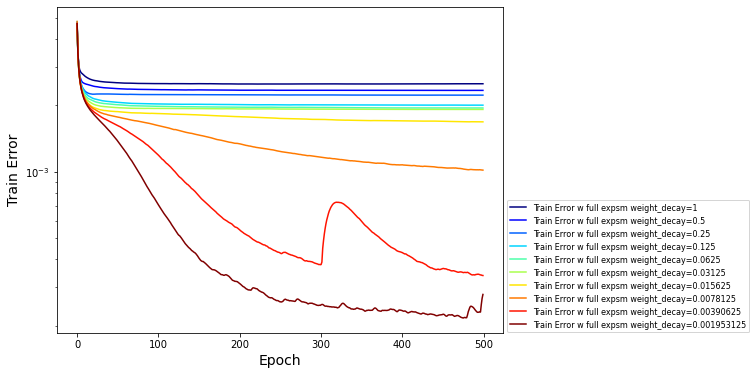

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
for i in training_loss:
    wd = i.split('_')[-1]
    ax.plot(training_loss[i], color=next(colors), label='Train Error w full expsm weight_decay=%s' % wd)
ax.set_yscale('log')
ax.legend(prop={'size': 8}, loc=2, bbox_to_anchor=(1, 0.42))
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Train Error",fontsize=14)
plt.show()
fig.savefig('Training_full_expsm_w_reg.png', dpi=fig.dpi, bbox_inches='tight')

In [13]:
smooth_loss_dict = {}
beta = 0.999

for i in testing_loss:
    running_loss = 0
    new_loss = []
    for index, loss in enumerate(testing_loss[i]):
        running_loss = beta*running_loss + (1-beta)*loss.cpu().numpy()
        new_loss.append( running_loss / (1-beta**(index+1)) )
    smooth_loss_dict[i] = new_loss
    
print(len(smooth_loss_dict))

10


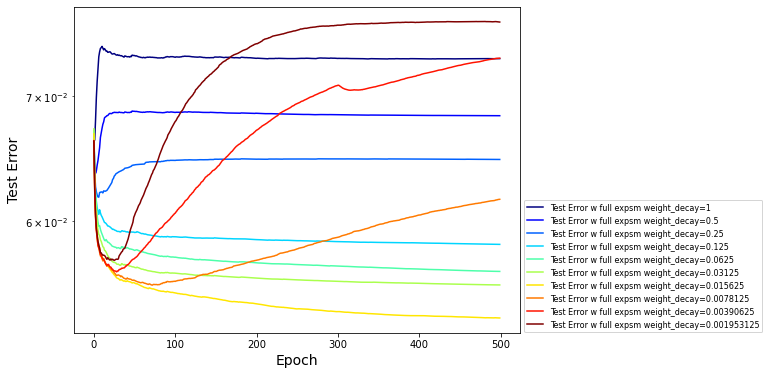

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
for i in smooth_loss_dict:
    wd = i.split('_')[-1]
    ax.plot(smooth_loss_dict[i], color=next(colors), label='Test Error w full expsm weight_decay=%s' % wd)
ax.set_yscale('log')
# ax.legend(loc=2, prop={'size': 1})
ax.legend(prop={'size': 8}, loc=2, bbox_to_anchor=(1, 0.42))
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Test Error",fontsize=14)
plt.show()
fig.savefig('Testing_full_expsm_w_reg.png', dpi=fig.dpi, bbox_inches='tight')

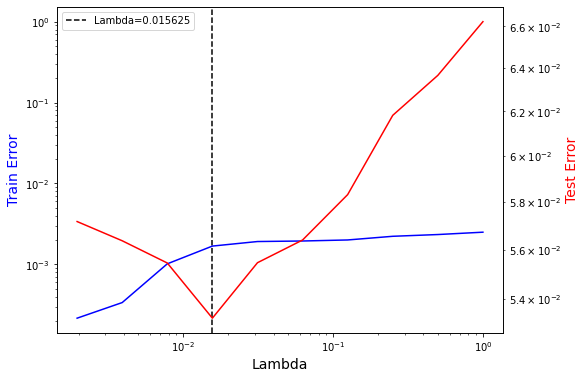

In [39]:
# Regularization vs Lambda curve

train_reg = []
test_reg = []

for i in training_loss:
    train_reg.append(min(training_loss[i]))
for i in smooth_loss_dict:
    test_reg.append(min(smooth_loss_dict[i]))
   
train_reg.reverse()
test_reg.reverse()

x = [2**-i for i in range(10)]
x.reverse()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, train_reg, color='b')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Lambda",fontsize=14)
ax.set_ylabel("Train Error",color="blue",fontsize=14)
ax2=ax.twinx()
ax2.plot(x, test_reg, color='r')
ax2.set_ylabel("Test Error",color="red",fontsize=14)
ax2.set_yscale('log')

ax.vlines(x[test_reg.index(min(test_reg))], 0, 1, color='black', 
          transform = ax.get_xaxis_transform(), linestyles='dashed', label='Lambda=%s' % x[test_reg.index(min(test_reg))])
ax.legend(loc=2)
plt.show()
fig.savefig('Train_Test_full_Lambda.png', dpi=fig.dpi)

In [43]:
# Summary Statistics

print("The minimum train MSE error for unnormalized spectrograms at lambda=%s is %s" 
      % (x[test_reg.index(min(test_reg))], round(train_reg[test_reg.index(min(test_reg))],5)) )

print("The minimum test MSE error for unnormalized spectrograms at lambda=%s is %s" 
      % (x[test_reg.index(min(test_reg))], round(min(test_reg),5)) )

print("Minimum training error at lambda=%s is %s" % (x[train_reg.index(min(train_reg))], round(min(train_reg),5)) )

The minimum train MSE error for unnormalized spectrograms at lambda=0.015625 is 0.00168
The minimum test MSE error for unnormalized spectrograms at lambda=0.015625 is 0.05324


In [8]:
# Training on optimized parameters

training_loss = {}
testing_loss = {}
criterion = nn.MSELoss()
batch_size = 128
n_iterations = X_combined_train.shape[0] // batch_size


beta = 0.999
running_loss = 0
c = 0
w = 0.015625
training_loss['training_loss_f_expsm_w_%s' % w] = []
testing_loss['testing_loss_f_expsm_w_%s' % w] = []
torch.manual_seed(0)    
net = Net(prob=0).cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.015625)

np.random.seed(1) # Seed for model trained on Sample 6
allTrainSamples = list(range((X_combined_train.shape[0])))

for epoch in range(500):  # loop over the dataset multiple times

    np.random.shuffle(allTrainSamples)

    for i in range(n_iterations):

        # get the inputs; data is a list of [inputs, labels]           
        inputs = X_combined_train[allTrainSamples[i*batch_size:(i+1)*batch_size],:,:,:]
        labels = Y_combined_train[allTrainSamples[i*batch_size:(i+1)*batch_size],:]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = beta*running_loss + (1-beta)*loss.item()
        c += 1

    with torch.no_grad():
        y_pred = net(X_combined_test.cuda())
        test_loss = criterion(y_pred, Y_combined_test.cuda())
    testing_loss['testing_loss_f_expsm_w_%s' % w].append(test_loss)
    training_loss['training_loss_f_expsm_w_%s' % w].append( running_loss / ( (1-beta**c) * n_iterations) )

    if epoch+1 == 500 or epoch == 0:    # print every start and end of training pass
        print(" Weight Decay: %f Epoch: %d Training Error: %.6f Testing Error: %.6f " 
                              % (0.015625, epoch+1, training_loss['training_loss_f_expsm_w_%s' % w][epoch]
                                                 , testing_loss['testing_loss_f_expsm_w_%s' % w][epoch]))
        print("----------------------------------")

 Weight Decay: 0.015625 Epoch: 1 Training Error: 0.004559 Testing Error: 0.066837 
----------------------------------
 Weight Decay: 0.015625 Epoch: 500 Training Error: 0.001637 Testing Error: 0.052356 
----------------------------------


In [9]:
# Getting the sample with minimum test error
criterion = nn.MSELoss(reduction='none')
y_pred = net(X_combined_test.cuda())
test_loss = criterion(y_pred, Y_combined_test.cuda())
loss_per_sample = torch.sum(test_loss, dim=1)
print("The index of the sample with the min loss ", (loss_per_sample == min(loss_per_sample)).nonzero(as_tuple=True)[0])

The index of the sample with the min loss  tensor([331], device='cuda:0')


In [27]:
torch.topk(loss_per_sample, 30, largest=True)

torch.return_types.topk(
values=tensor([1.3307, 1.2763, 1.2346, 1.0194, 0.9847, 0.9818, 0.9716, 0.9615, 0.9510,
        0.9274, 0.9219, 0.9122, 0.9011, 0.9008, 0.8914, 0.8682, 0.8671, 0.8469,
        0.8290, 0.8091, 0.8071, 0.7898, 0.7823, 0.7730, 0.7249, 0.7222, 0.6868,
        0.6780, 0.6541, 0.6101], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([ 46, 932,   0, 881, 431, 158, 557, 749,   4, 541,  55, 108,  54,  70,
        337, 735, 850, 712, 698,  42, 846, 529, 178, 764, 543, 156, 518, 382,
        578, 103], device='cuda:0'))

In [36]:
# Get the original location with predicted location
y_pred = net(X_combined_test[431:431+1,:,:,:].cuda()).cpu().detach().numpy()
y_gt = Y_combined_test[431,:].cuda().cpu().numpy()
print(y_pred, y_gt)

[[0.8030648 0.2844584]] [0.02  0.894]


[[0.8025894  0.42873544]] [0.809 0.394]


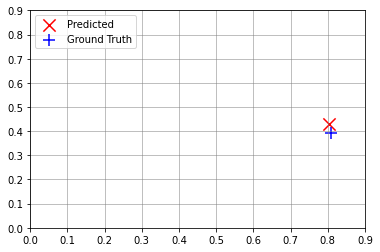

In [159]:
# Get the original location with predicted location
y_pred = net(X_combined_test[152:152+1,:,:,:].cuda()).cpu().detach().numpy()
y_gt = Y_combined_test[152,:].cuda().cpu().numpy()
print(y_pred, y_gt)

# Display the original and predicted locations
fig, ax = plt.subplots()

ax.scatter(y_pred[0][0], y_pred[0][1], color='red', label='Predicted', marker='x', s=150)
ax.scatter(y_gt[0], y_gt[1], color='blue', label='Ground Truth', marker='+', s=150)
ax.set_facecolor('1')
# ax.set_title('Prediction vs Ground Truth Comparision', fontsize = 12)
ax.set_xticks(numpy.arange(0, 1, 0.1))
ax.set_yticks(numpy.arange(0, 1, 0.1))
ax.legend(loc=2)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
fig.savefig('Predicted_GT_SO_2.png', dpi=fig.dpi, bbox_inches='tight')

[[0.83133566 0.48409915]] [0.868 0.493]


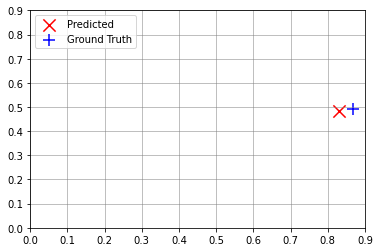

In [160]:
# Get the original location with predicted location
y_pred = net(X_combined_test[761:761+1,:,:,:].cuda()).cpu().detach().numpy()
y_gt = Y_combined_test[761,:].cuda().cpu().numpy()
print(y_pred, y_gt)
# Display the original and predicted locations
fig, ax = plt.subplots()

ax.scatter(y_pred[0][0], y_pred[0][1], color='red', label='Predicted', marker='x', s=150)
ax.scatter(y_gt[0], y_gt[1], color='blue', label='Ground Truth', marker='+', s=150)
ax.set_facecolor('1')
# ax.set_title('Prediction vs Ground Truth Comparision', fontsize = 12)
ax.set_xticks(numpy.arange(0, 1, 0.1))
ax.set_yticks(numpy.arange(0, 1, 0.1))
ax.legend(loc=2)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
fig.savefig('Predicted_GT_SO_3.png', dpi=fig.dpi, bbox_inches='tight')

## How do bad predictions look like?

In [162]:
torch.topk(loss_per_sample, 30, largest=True)

torch.return_types.topk(
values=tensor([1.3252, 1.3161, 1.1889, 1.0028, 0.9853, 0.9401, 0.9380, 0.9233, 0.9196,
        0.8932, 0.8929, 0.8902, 0.8811, 0.8754, 0.8646, 0.8625, 0.8479, 0.7910,
        0.7721, 0.7667, 0.7632, 0.7472, 0.7409, 0.7399, 0.7351, 0.7012, 0.6903,
        0.6764, 0.6644, 0.6304], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([ 46, 932,   0,   4, 749, 881, 158, 557,  70, 108, 337,  55, 431, 541,
        712, 735, 850, 529, 543, 846,  42, 518, 178, 156, 764,  54, 698, 578,
        382, 633], device='cuda:0'))

In [163]:
# Get the original location with predicted location
y_pred = net(X_combined_test[46:46+1,:,:,:].cuda()).cpu().detach().numpy()
y_gt = Y_combined_test[46,:].cuda().cpu().numpy()
print(y_pred, y_gt)

[[0.9110279  0.16673847]] [0.013 0.887]


[[0.8671428 0.4872209]] [0.086 0.345]


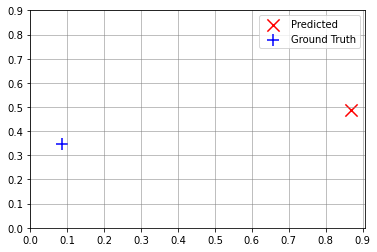

In [166]:
# Get the original location with predicted location
y_pred = net(X_combined_test[633:633+1,:,:,:].cuda()).cpu().detach().numpy()
y_gt = Y_combined_test[633,:].cuda().cpu().numpy()
print(y_pred, y_gt)
# Display the original and predicted locations
fig, ax = plt.subplots()

ax.scatter(y_pred[0][0], y_pred[0][1], color='red', label='Predicted', marker='x', s=150)
ax.scatter(y_gt[0], y_gt[1], color='blue', label='Ground Truth', marker='+', s=150)
ax.set_facecolor('1')
# ax.set_title('Prediction vs Ground Truth Comparision', fontsize = 12)
ax.set_xticks(numpy.arange(0, 1, 0.1))
ax.set_yticks(numpy.arange(0, 1, 0.1))
ax.legend(loc=1)
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# fig.savefig('Predicted_GT_SO_4.png', dpi=fig.dpi, bbox_inches='tight')

### Heat Map of Training and Testing Samples

In [201]:
import seaborn as sns

In [385]:
total_hm_array = np.zeros((10,10))
total_sum = 0
for x in range(10):
    for y in range(10):
        count = 0
        for index in range(Y_combined.shape[0]):
            if (x/10 < Y_combined[index,:][0] <= (x+1)/10 and y/10 < Y_combined[index,:][1] <= (y+1)/10):
                count += 1
            else:
                continue
#         total_hm_array[x][y] = np.round(count/Y_combined.shape[0],5)
        total_hm_array[y][x] = count/Y_combined.shape[0]
np.sum(total_hm_array)

1.0

In [310]:
test_hm_array = np.zeros((10,10))
total_sum = 0
for x in range(10):
    for y in range(10):
        count = 0
        for index in range(Y_combined_test.shape[0]):
            if (x/10 < Y_combined_test[index,:][0] <= (x+1)/10 and y/10 < Y_combined_test[index,:][1] <= (y+1)/10):
                count += 1
            else:
                continue
#         test_hm_array[x][y] = np.round(count/Y_combined_test.shape[0],5)
        test_hm_array[y][x] = count/Y_combined_test.shape[0]
np.sum(test_hm_array)

1.0

In [312]:
train_hm_array = np.zeros((10,10))
total_sum = 0
for x in range(10):
    for y in range(10):
        count = 0
        for index in range(Y_combined_train.shape[0]):
            if (x/10 < Y_combined_train[index,:][0] <= (x+1)/10 and y/10 < Y_combined_train[index,:][1] <= (y+1)/10):
                count += 1
            else:
                continue
#         train_hm_array[x][y] = np.round(count/Y_combined_train.shape[0],5)
        train_hm_array[y][x] = count/Y_combined_train.shape[0]
np.sum(train_hm_array)

0.9999999999999999

Text(51.0, 0.5, 'y coordinate')

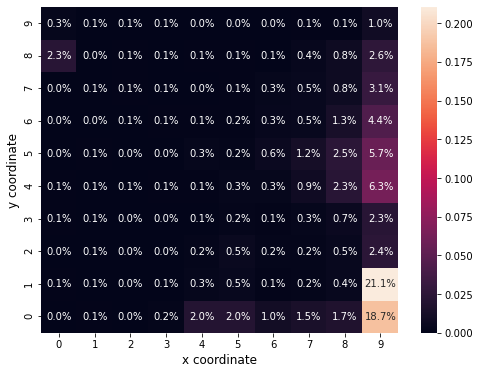

In [409]:
# Heatmap for total samples
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(total_hm_array, vmin=0, vmax=np.max(total_hm_array), annot=True, fmt=".1%")
ax.invert_yaxis()
ax.set_xlabel("x coordinate",fontsize=12)
ax.set_ylabel("y coordinate",fontsize=12)
# ax.figure.savefig('Total_HM_SO_2.png', dpi=fig.dpi, bbox_inches='tight')

Text(51.0, 0.5, 'y coordinate')

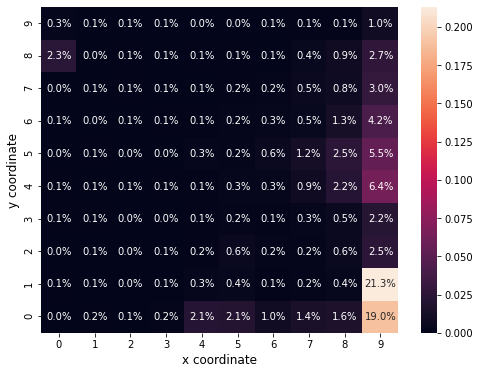

In [408]:
# Heatmap for training samples
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(train_hm_array, vmin=0, vmax=np.max(train_hm_array), annot=True, fmt=".1%")
ax.invert_yaxis()
ax.set_xlabel("x coordinate",fontsize=12)
ax.set_ylabel("y coordinate",fontsize=12)
# ax.figure.savefig('Train_HM_SO_2.png', dpi=fig.dpi, bbox_inches='tight')

Text(51.0, 0.5, 'y coordinate')

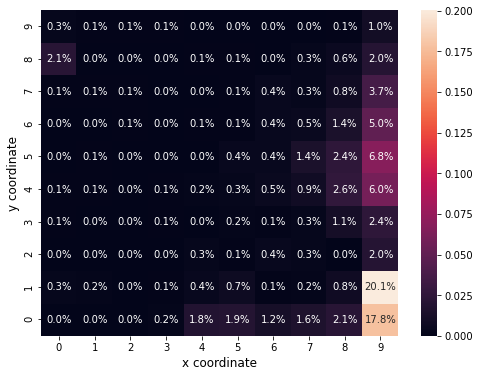

In [407]:
# Heatmap for testing samples
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(test_hm_array, vmin=0, vmax=np.max(test_hm_array), annot=True, fmt=".1%")
ax.invert_yaxis()
ax.set_xlabel("x coordinate",fontsize=12)
ax.set_ylabel("y coordinate",fontsize=12)
# ax.figure.savefig('Test_HM_SO_2.png', dpi=fig.dpi, bbox_inches='tight')

In [356]:
criterion = nn.MSELoss(reduction='none')
y_pred = net(X_combined_test[475:475+1,:,:,:].cuda().cuda())
test_loss = criterion(y_pred, Y_combined_test[475,:].cuda())
loss_per_sample = torch.sum(test_loss).cpu().detach().numpy()
loss_per_sample

array(0.00030415, dtype=float32)

In [410]:
# Calculate MSE on grid
test_mse = np.zeros((10,10))
loss_per_grid = 0
for x in range(10):
    for y in range(10):
        loss_per_grid = 0
        for index in range(Y_combined_test.shape[0]):
            if (x/10 < Y_combined_test[index,:][0] <= (x+1)/10 and y/10 < Y_combined_test[index,:][1] <= (y+1)/10):
                y_pred = net(X_combined_test[index:index+1,:,:,:].cuda().cuda())
                test_loss = criterion(y_pred, Y_combined_test[index,:].cuda())
                loss_per_sample = torch.sum(test_loss).cpu().detach().numpy()
                loss_per_grid = loss_per_grid + loss_per_sample
            else:
                continue
        if test_hm_array[y][x] != 0:
            test_mse[y][x] = loss_per_grid/(test_hm_array[y][x]*Y_combined_test.shape[0])
        else:
            test_mse[y][x] = 0

Text(51.0, 0.5, 'y coordinate')

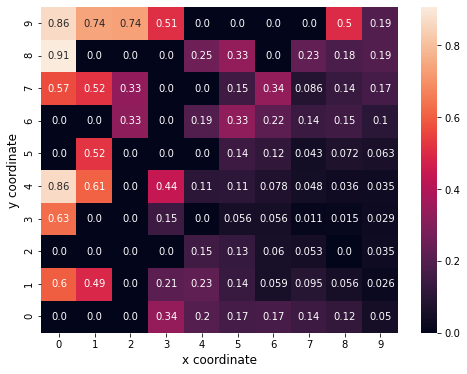

In [413]:
# PLotting MSE in a heatmap 
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(updated_test_mse, vmin=0, vmax=np.max(test_mse), annot=True, fmt=".2")
ax.invert_yaxis()
ax.set_xlabel("x coordinate",fontsize=12)
ax.set_ylabel("y coordinate",fontsize=12)
# ax.figure.savefig('Test_MSE_SO_2.png', dpi=fig.dpi, bbox_inches='tight')